In [1]:
import json
import numpy
import torch
from dalle import VQGanDetokenizer, DalleBartEncoder, DalleBartDecoder, TextTokenizer
with open('models/vocab.json', 'r', encoding='utf8') as f:
    vocab = json.load(f)
with open('models/merges.txt', 'r', encoding='utf8') as f:
    merges = f.read().split("\n")[1:-1]
tokenizer = TextTokenizer(vocab, merges)
detokenizer = VQGanDetokenizer()
detokenizer.load_state_dict(torch.load('models/detoker.pt'))
detokenizer = detokenizer.cuda().eval()
encoder = DalleBartEncoder(attention_head_count=32, embed_count=2048, glu_embed_count=4096, text_token_count=64, text_vocab_count=50272, layer_count=24, device='cpu').eval()
encoder.load_state_dict(torch.load('models/encoder.pt'), strict=False)
decoder = DalleBartDecoder(image_vocab_count=16415, attention_head_count=32, embed_count=2048, glu_embed_count=4096, layer_count=24, device='cuda').eval().to(torch.float16).cuda()
decoder.load_state_dict(torch.load('models/decoder.pt'), strict=False)
torch.cuda.empty_cache()

In [2]:
TEXT = 'new york skyscraper'

In [3]:
image_count = 1
tokens = tokenizer.tokenize(TEXT, is_verbose=False)[:64]

text_tokens = numpy.ones((2, 64), dtype=numpy.int32)
text_tokens[0, :2] = [tokens[0], tokens[-1]]
text_tokens[1, :len(tokens)] = tokens
text_tokens = torch.tensor(
    text_tokens, 
    dtype=torch.long, 
    device='cpu'
)
with torch.cuda.amp.autocast(dtype=torch.float32) and torch.no_grad():
    encoder_state = encoder.forward(text_tokens)

In [4]:
SEED = 42
TEMPERATURE = 1.0
TOPK = 256
SFACTOR = 16

In [5]:
from tqdm import tqdm
image_count = 1
with torch.cuda.amp.autocast(dtype=torch.float16) and torch.no_grad():
    expanded_indices = [0] * image_count + [1] * image_count
    text_tokens = text_tokens[expanded_indices]
    encoder_state = encoder_state[expanded_indices].half().cuda()
    attention_mask = text_tokens.not_equal(1).long().cuda()
    attention_state = torch.zeros(size=(24, image_count * 4, 256, 2048), device='cuda').half()
    image_tokens = torch.full((256 + 1, image_count), 16415, dtype=torch.long, device='cuda')
    torch.manual_seed(SEED)
    token_indices = torch.arange(256, device='cuda').repeat(4)
    settings = torch.tensor([TEMPERATURE, TOPK, SFACTOR], dtype=torch.float16, device='cuda')
    
for i in tqdm(range(256)):
    torch.cuda.empty_cache()
    with torch.cuda.amp.autocast(dtype=torch.float16) and torch.no_grad():
        logits, attention_state = decoder.forward(
            attention_mask=attention_mask,
            encoder_state=encoder_state,
            attention_state=attention_state,
            prev_tokens=image_tokens[i],
            token_index=token_indices[[i]]
        )
        logits = logits[:, -1, : 2 ** 14]
        temperature = settings[[0]]
        top_k = settings[[1]].to(torch.long)
        supercondition_factor = settings[[2]]
        logits = (
            logits[:image_count] * (1 - supercondition_factor) + 
            logits[image_count:] * supercondition_factor
        )
        logits_sorted, _ = logits.sort(descending=True)
        is_kept = logits >= logits_sorted[:, top_k - 1]
        logits -= logits_sorted[:, [0]]
        logits /= temperature
        logits.exp_()
        logits *= is_kept.to(torch.float32)
        image_tokens[i + 1] = torch.multinomial(logits, 1)[:, 0]
torch.cuda.empty_cache()

100%|██████████| 256/256 [00:57<00:00,  4.44it/s]


In [6]:
with torch.cuda.amp.autocast(dtype=torch.float32) and torch.no_grad():
    z = image_tokens[1:].T.reshape(-1, 256)
    z.clamp_(0, detokenizer.vocab_count - 1)
    t1 = 1 * 2 ** 4
    t2 = 1 * 2 ** 4
    # z = z.view([4, 1, 2 ** 4, 2 ** 4])
    # z = z.flatten(1, 2).transpose(1, 0).flatten(1, 2)
    # z = z.flatten().unsqueeze(1)
    z = detokenizer.embedding.forward(z)
    z = z.view((z.shape[0], t1, t2, 2 ** 8))
    z = z.permute(0, 3, 1, 2).contiguous()
    z = detokenizer.post_quant_conv.forward(z)
    z = detokenizer.decoder.forward(z, t1, t2)
    z = z.permute(0, 2, 3, 1)
    images = (z.clip(0.0, 1.0) * 255).cpu().detach()

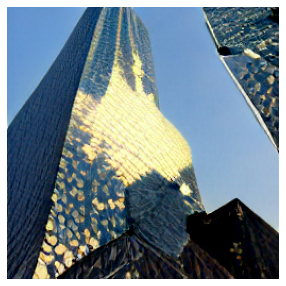

In [7]:
import pylab as plt
plt.figure(figsize=(5,5))
plt.imshow(images[-1] / 255.)
plt.axis('off')
plt.show()

In [21]:
images.shape

torch.Size([4, 256, 256, 3])

In [22]:
import torchvision
grid = torchvision.utils.make_grid(images.movedim(-1,1), nrow=2)
grid.shape

torch.Size([3, 518, 518])

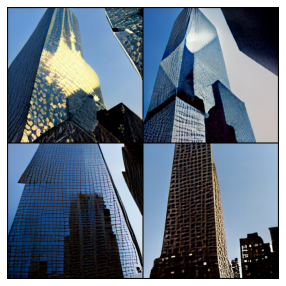

In [24]:
import pylab as plt
plt.figure(figsize=(5,5))
plt.imshow(grid.movedim(0,-1) / 255.)
plt.axis('off')
plt.show()